In [2]:
#EDIT ME to change target subreddit...
subreddit1 = "Naruto" # scraped data includes: ['Naruto', 'BokuNoHeroAcademia', 'anime', 'manga', 'comicbooks',
                                                    # 'StarWars', 'startrek', 'LonghornNation', 'cfb', 'Genshin_Impact']
subreddit2 = "anime"
scrape_type = "submission"  # set to "submission" or "comment"

# Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #plot_confusion_matrix is same thing(?)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier #, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Read in data
subreddit1_df = pd.read_csv(f'./data/{subreddit1}_{scrape_type}s_preprocessed.csv')
subreddit2_df = pd.read_csv(f'./data/{subreddit2}_{scrape_type}s_preprocessed.csv')

In [5]:
subreddit1_df.shape

(4887, 20)

In [6]:
subreddit2_df.shape

(4734, 20)

In [7]:
all_data = pd.concat([subreddit1_df, subreddit2_df], axis=0)

In [8]:
all_data.columns

Index(['subreddit', 'selftext', 'author_fullname', 'title', 'upvote_ratio',
       'is_reddit_media_domain', 'domain', 'over_18', 'spoiler', 'id',
       'author', 'num_comments', 'created_utc', 'is_video', 'created_datetime',
       'combined_text', 'combined_text_length', 'combined_wordcount',
       'lemmatized_text', 'tokenized_text'],
      dtype='object')

In [9]:
# X = all_data['tokenized_text']
X = all_data['combined_text']
y = all_data['subreddit']

# Baseline

In [10]:
#Finding the baseline.  Higher value is the baseline (i.e., if we just simply guessed everything was of the bigger category)
y.value_counts(normalize=True)

Naruto    0.507951
anime     0.492049
Name: subreddit, dtype: float64

In [11]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,  #keeps approx same balance of y in both the train & split?
                                                    random_state=42)

# Data Exploration

In [38]:
# Top 15 most common words

cvec1 = CountVectorizer(stop_words="english")
cvec1.fit(X_train)
X_train_cvectorized = cvec1.transform(X_train)

X_train_df = pd.DataFrame(X_train_cvectorized.todense(), columns = cvec1.get_feature_names_out())
top15 = X_train_df.sum().sort_values(ascending=False).head(15)
top15

https      5497
anime      4320
naruto     2544
like       1784
episode    1710
com        1681
redd       1490
link       1470
just       1457
youpoll    1352
amp        1226
sasuke      945
know        917
think       905
watch       791
dtype: int64

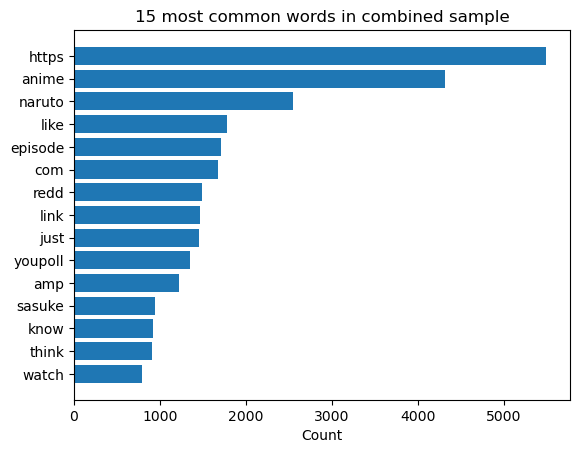

In [24]:
plt.barh(top15.index[::-1], top15[::-1],label=top15) ;
plt.title('15 most common words in combined sample')
plt.xlabel('Count');

In [32]:
# Top 15 most common bigrams

cvec2 = CountVectorizer(ngram_range=(2,2), stop_words="english")
cvec2.fit(X_train)
bigrams = cvec2.transform(X_train)

bigrams_df = pd.DataFrame(bigrams.todense(), columns = cvec2.get_feature_names_out())
top15bigrams = bigrams_df.sum().sort_values(ascending=False).head(15)
top15bigrams

https youpoll        1352
https redd           1334
link https           1253
https www             700
familiar zero         515
https imgur           492
imgur com             491
2023 familiar         490
zero episode          490
com anime             472
reddit com            406
www reddit            268
myanimelist net       253
https myanimelist     247
net anime             234
dtype: int64

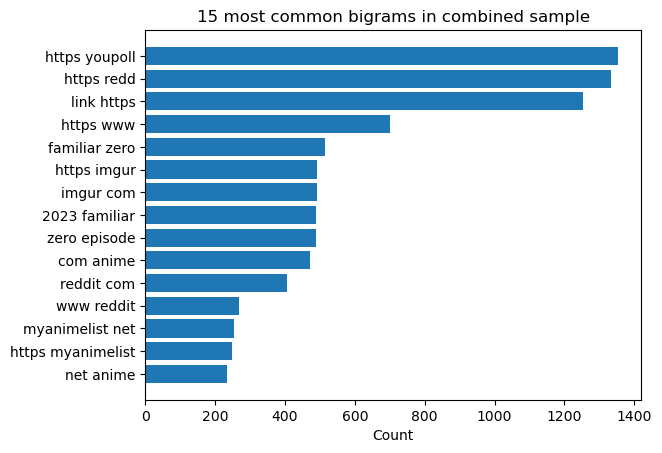

In [33]:
plt.barh(top15bigrams.index[::-1], top15bigrams[::-1],label=top15bigrams) ;
plt.title('15 most common bigrams in combined sample')
plt.xlabel('Count');

In [36]:
# Top 15 most common bigrams

cvec3 = CountVectorizer(ngram_range=(3,3), stop_words="english")
cvec3.fit(X_train)
trigrams = cvec3.transform(X_train)

trigrams_df = pd.DataFrame(trigrams.todense(), columns = cvec3.get_feature_names_out())
top15trigrams = trigrams_df.sum().sort_values(ascending=False).head(15)
top15trigrams

link https redd          1239
https imgur com           491
familiar zero episode     490
2023 familiar zero        490
www reddit com            268
https www reddit          266
https myanimelist net     247
reddit com anime          224
com anime comments        217
myanimelist net anime     183
poll https www            175
view poll https           175
reddit com poll           175
anilist https anilist     172
https anilist anime       167
dtype: int64

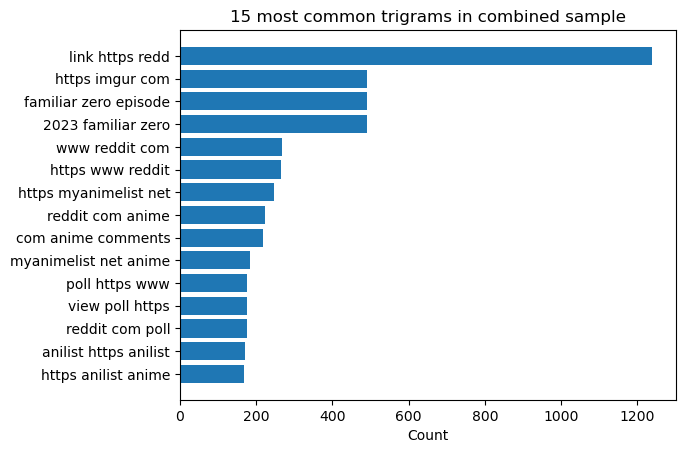

In [37]:
plt.barh(top15trigrams.index[::-1], top15trigrams[::-1],label=top15trigrams) ;
plt.title('15 most common trigrams in combined sample')
plt.xlabel('Count');

# Naive Bayes in a GridSearch

In [11]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [12]:
pipe_params = {
    'cvec__stop_words': [None, "english"],
    'cvec__max_features': [1000, 5000, 10_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.4, 0.6, 0.8],  # 'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 3), (2, 3)],
}

In [13]:
gs_nb = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what params am I searching over?
                  cv = 5,   # 5 fold cross validation
                  n_jobs=8
)

In [14]:
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.4, 0.6, 0.8],
                         'cvec__max_features': [1000, 5000, 10000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 3), (2, 3)],
                         'cvec__stop_words': [None, 'english']})

In [15]:
gs_nb.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [16]:
gs_nb.score(X_train, y_train)

0.9025641025641026

In [17]:
gs_nb.score(X_test, y_test)

0.8628428927680798

In [18]:
# Get predictions
preds_nb = gs_nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_nb).ravel()

In [19]:
# Calculate the accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

0.8628428927680798

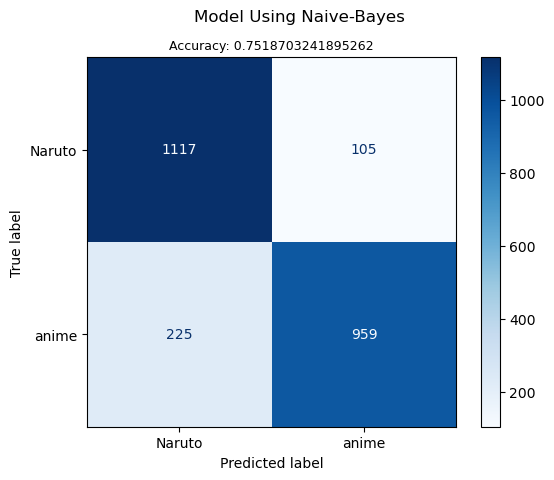

In [55]:
ConfusionMatrixDisplay.from_estimator(gs_nb, X_test, y_test, cmap = "Blues") ;
plt.suptitle('Model Using Naive-Bayes');  # Reference: Jack Vaughan
plt.title(f'Accuracy: {accuracy}', {'fontsize':9});

# TfidfVectorizer in a GridSearch

In [21]:
tvec = TfidfVectorizer()

In [22]:
X_train_df2 = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                         columns=tvec.get_feature_names_out())
X_train_df2.sum().sort_values(ascending=False).head(20)

the       420.671641
to        259.597422
and       252.975368
anime     248.547343
of        226.346107
is        223.409755
it        213.117619
naruto    208.003781
in        185.389801
this      182.251495
you       154.586834
what      153.637096
that      150.395935
for       137.181158
https     133.777163
was       121.325866
me        120.649824
my        114.574784
on        112.332787
he        110.540257
dtype: float64

In [23]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [24]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 4000, 8000, 12000],
    'tvec__stop_words': [None,"english"],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
    # 'tvec__tokenizer': ______,  --- this would typically be a good one to throw in also
}

In [25]:
gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv=5,
                      n_jobs=8)

In [26]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'tvec__max_features': [2000, 4000, 8000, 12000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [27]:
gs_tvec.best_params_

{'tvec__max_features': 12000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [28]:
gs_tvec.score(X_train, y_train)

0.9241857241857242

In [29]:
gs_tvec.score(X_test, y_test)

0.8711554447215295

In [30]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

In [31]:
# Calculate the accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

0.8711554447215295

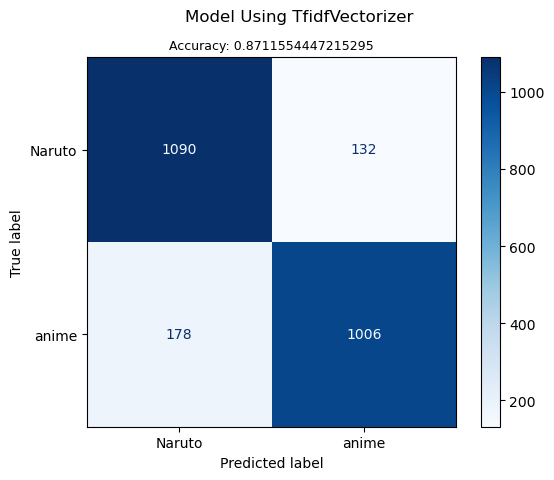

In [32]:
ConfusionMatrixDisplay.from_estimator(gs_tvec, X_test, y_test, cmap = "Blues") ;
plt.suptitle('Model Using TfidfVectorizer');  # Reference: Jack Vaughan
plt.title(f'Accuracy: {accuracy}', {'fontsize':9});

# Random Forest in a GridSearch

In [33]:
rf = RandomForestClassifier(n_jobs=8)
# et = ExtraTreesClassifier(n_jobs=8)

In [34]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [35]:
# DROP SOME PARAMS IF RUNNING AGAIN--- THIS ONE TOOK FOREVER TO RUN!

pipe_rf_params = {
    'cvec__stop_words': [None, "english"],
    'cvec__max_features': [10_000], #[1000, 5000, 10_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.4, 0.6, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 3), (2, 3)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3] #[None, 1, 2, 3, 4, 5, 6, 7]
}

In [36]:
gs_rf = GridSearchCV(pipe_rf,
                      param_grid = pipe_rf_params,
                      cv=5,
                      n_jobs=8)

In [37]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.4, 0.6, 0.8],
                         'cvec__max_features': [10000], 'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 3), (2, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__max_depth': [None, 1, 2, 3],
                         'rf__n_estimators': [100, 150, 200]})

In [38]:
gs_rf.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': None,
 'rf__n_estimators': 100}

In [39]:
gs_rf.score(X_train, y_train)

0.9944559944559944

In [40]:
gs_rf.score(X_test, y_test)

0.8802992518703242

In [41]:
# Get predictions
preds_rf = gs_rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

In [42]:
# Calculate the accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

0.8802992518703242

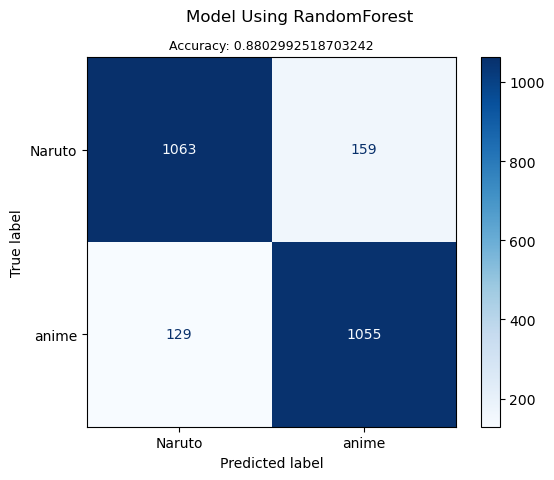

In [43]:
ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test, cmap = "Blues") ;
plt.suptitle('Model Using RandomForest');  # Reference: Jack Vaughan
plt.title(f'Accuracy: {accuracy}', {'fontsize':9});

# K Nearest Neighbors

In [44]:
# knn = KNeighborsClassifier(n_neighbors=5)

In [45]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [46]:
pipe_knn_params = {
    'cvec__stop_words': [None, "english"],
    'cvec__max_features': [10_000],  #[1000, 5000, 10_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.4, 0.6, 0.8],  # 'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1)],   #[(1, 1), (1, 3), (2, 3)],
    'knn__n_neighbors': [5, 10],
}

In [47]:
gs_knn = GridSearchCV(pipe_knn,
                      param_grid = pipe_knn_params,
                      cv=5,
                      n_jobs=8)

In [48]:
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.4, 0.6, 0.8],
                         'cvec__max_features': [10000], 'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None, 'english'],
                         'knn__n_neighbors': [5, 10]})

In [49]:
gs_knn.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 10000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'knn__n_neighbors': 5}

In [50]:
gs_knn.score(X_train, y_train)

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.8332640332640333

In [51]:
gs_knn.score(X_test, y_test)

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7518703241895262

In [52]:
# Get predictions
preds_knn = gs_knn.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_knn).ravel()

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [53]:
# Calculate the accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

0.7518703241895262

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


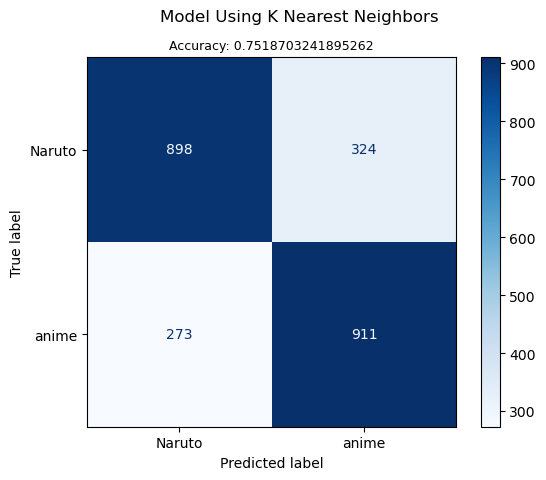

In [54]:
ConfusionMatrixDisplay.from_estimator(gs_knn, X_test, y_test, cmap = "Blues") ;
plt.suptitle('Model Using K Nearest Neighbors');  # Reference: Jack Vaughan
plt.title(f'Accuracy: {accuracy}', {'fontsize':9});